In [1]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import numpy as np

# Define the physical constants
E = 21e10  # Young's modulus (Pa)
nu = 0.3  # Poisson's ratio
L = 25.0  # Length of the plate (m)
H = 1.0  # Height of the plate (m)
lambda_reg =0.0001# Regularization parameter
lambda_ = (E * nu) / ((1 + nu) * (1 - 2 * nu))  
mu = E / (2 * (1 + nu))  
rho = 7800  # Density
g = 9.81  # Gravity acceleration

sigma_char = E
x_char = L
y_char = H
u_char = nu *rho * g * L**2 / (2*E)
v_char = rho * g * L**2 / (2*E)

def nondimensionalize(val, char):
    return val / char

def dimensionalize_displacement(u_nd, v_nd, scale_factor):
    return u_nd * u_char * scale_factor, v_nd * v_char * scale_factor

def dimensionalize_stress(sigma_xx_nd, sigma_yy_nd, sigma_xy_nd):
    return sigma_xx_nd * sigma_char, sigma_yy_nd * sigma_char, sigma_xy_nd * sigma_char

class SeparablePINN(eqx.Module):
    x_net: eqx.nn.MLP
    y_net: eqx.nn.MLP
    latent_size: int

    def __init__(self, key, latent_size=144):
        keys = jax.random.split(key, 6)
        self.latent_size = latent_size
        self.x_net = eqx.nn.MLP(
            in_size=2, out_size=latent_size * 2, width_size=128, depth=3, key=keys[0], activation=jax.nn.leaky_relu
        )
        self.y_net = eqx.nn.MLP(
            in_size=2, out_size=latent_size * 2, width_size=128, depth=3, key=keys[1], activation=jax.nn.leaky_relu
        )

    def __call__(self, x, y):
        x_latent_matrix = self.x_net(jnp.stack([x, y], axis=-1))
        y_latent_matrix = self.y_net(jnp.stack([x, y], axis=-1))

        x_latent_matrix = x_latent_matrix.reshape(self.latent_size, 2)
        y_latent_matrix = y_latent_matrix.reshape(self.latent_size, 2)

        final_output = jnp.einsum('ij,ij->j', x_latent_matrix, y_latent_matrix)

        return final_output

def pde_residual(model, x, y):

    u, v = model(x, y)
    u_x = jax.grad(lambda x: model(x, y)[0])(x)
    u_y = jax.grad(lambda y: model(x, y)[0])(y)
    v_x = jax.grad(lambda x: model(x, y)[1])(x)
    v_y = jax.grad(lambda y: model(x, y)[1])(y)
    
    epsilon_xx = u_x
    epsilon_yy = v_y
    epsilon_xy = 0.5 * (u_y + v_x)

    sigma_xx = lambda_ * (epsilon_xx + epsilon_yy) + 2 * mu * epsilon_xx
    sigma_yy = lambda_ * (epsilon_xx + epsilon_yy) + 2 * mu * epsilon_yy
    sigma_xy = 2 * mu * epsilon_xy

    sigma_xx_x = jax.grad(lambda x: lambda_ * (jax.grad(lambda x: model(x, y)[0])(x)+ jax.grad(lambda y: model(x, y)[1])(y) )+ 2 * mu * jax.grad(lambda x: model(x, y)[0])(x))(x)
    sigma_xy_y = jax.grad(lambda y: mu * (jax.grad(lambda y: model(x, y)[0])(y) + jax.grad(lambda x: model(x, y)[1])(x)))(y)
    sigma_yy_y = jax.grad(lambda y: lambda_ * (jax.grad(lambda x: model(x, y)[0])(x) + jax.grad(lambda y: model(x, y)[1])(y) )+ 2 * mu * jax.grad(lambda y: model(x, y)[1])(y))(y)
    sigma_xy_x = jax.grad(lambda x: mu * (jax.grad(lambda y: model(x, y)[0])(y) + jax.grad(lambda x: model(x, y)[1])(x)))(x)


    res_x = (sigma_xx_x + sigma_xy_y) 
    res_y =( sigma_xy_x + sigma_yy_y + rho * g) 

    return res_x, res_y   


def loss_fn(model, x, y):
    x_nd = nondimensionalize(x, x_char)
    y_nd = nondimensionalize(y, y_char)

    res_x, res_y = jax.vmap(pde_residual, in_axes=(None, 0, 0))(model, x_nd, y_nd)
    pde_loss = jnp.mean(res_x**2 + res_y**2)

    def left_boundary_loss(y):
        return 19.5*jnp.square(model(0.0, y)[0])

    def bottom_boundary_loss(x):
        return 18.49*jnp.square(model(x, 0.0)[1])
        
    def horizontal_smoothing(x, y):
        u_x = jax.grad(lambda x: model(x, y)[0])(x)
        return jnp.square(u_x) 
        
    
    u_v_left = jax.vmap(left_boundary_loss)(y_nd)
    u_v_bottom = jax.vmap(bottom_boundary_loss)(x_nd)
    smoothing_penalty_u = jnp.mean(jax.vmap(horizontal_smoothing)(x_nd, y_nd))
    bc_loss =(
        jnp.mean(u_v_left) + 
        jnp.mean(u_v_bottom)  
      
    )

    params = eqx.filter(model, eqx.is_inexact_array)
    l2_reg = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))


    total_loss = pde_loss + bc_loss + lambda_reg * l2_reg
    
    return total_loss


@eqx.filter_value_and_grad
def loss_and_grad(model, x, y):
    return loss_fn(model, x, y)


@eqx.filter_jit
def train_step(model, opt_state, x, y):
    loss, grads = loss_and_grad(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


key = jax.random.PRNGKey(42)
model_2D = SeparablePINN(key)
learning_rate_fn = optax.exponential_decay(
    init_value=1e-4,  
    transition_steps=1000, 
    decay_rate=0.95  
)
optimizer = optax.adam(learning_rate=learning_rate_fn)
opt_state = optimizer.init(eqx.filter(model_2D, eqx.is_array))

# Training data
x_train = jnp.linspace(0, L, 200)
y_train = jnp.linspace(0, H, 200)

# Training loop
num_epochs =10000
Loss_value = np.zeros(num_epochs)
for epoch in range(num_epochs):
    model_2D, opt_state, loss = train_step(model_2D, opt_state, x_train, y_train)
    Loss_value[epoch] = loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

Epoch 0, Loss: 3.7876205252046225e+19
Epoch 100, Loss: 6.906358264380785e+17
Epoch 200, Loss: 3.2014744635939226e+17
Epoch 300, Loss: 1.3308638207462605e+17
Epoch 400, Loss: 1.1151641206901965e+17
Epoch 500, Loss: 8.334977602368307e+16
Epoch 600, Loss: 5.860351019896013e+16
Epoch 700, Loss: 3.949709477963366e+16
Epoch 800, Loss: 3.050736959933645e+16
Epoch 900, Loss: 2.6129374143053824e+16
Epoch 1000, Loss: 2.611088645632819e+16
Epoch 1100, Loss: 2.166096103525581e+16
Epoch 1200, Loss: 1.646144463568896e+16
Epoch 1300, Loss: 1.7471558666682368e+16
Epoch 1400, Loss: 1.623557230559232e+16
Epoch 1500, Loss: 5.07172329839657e+16
Epoch 1600, Loss: 1.7198883004219392e+16
Epoch 1700, Loss: 1.2293881102073856e+16
Epoch 1800, Loss: 1.2195925782953984e+16
Epoch 1900, Loss: 1.336452625465344e+16
Epoch 2000, Loss: 1.1994294248275968e+16
Epoch 2100, Loss: 1.3727846128156672e+16
Epoch 2200, Loss: 1.1337421950025728e+16
Epoch 2300, Loss: 7108346431668224.0
Epoch 2400, Loss: 8980451809034240.0
Epoch 2

[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -1.03136384e-07
 -1.03136384e-07 -1.03136384e-07]


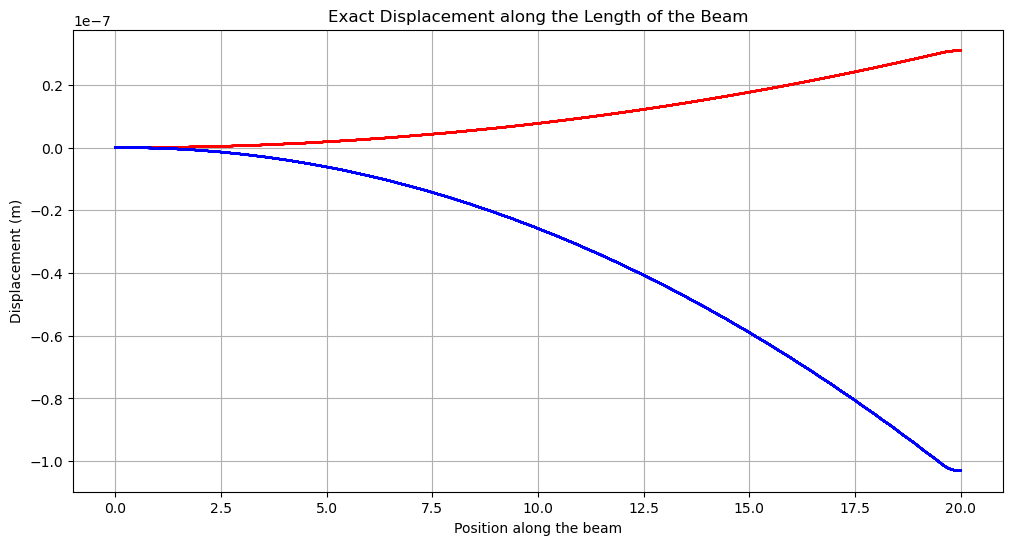

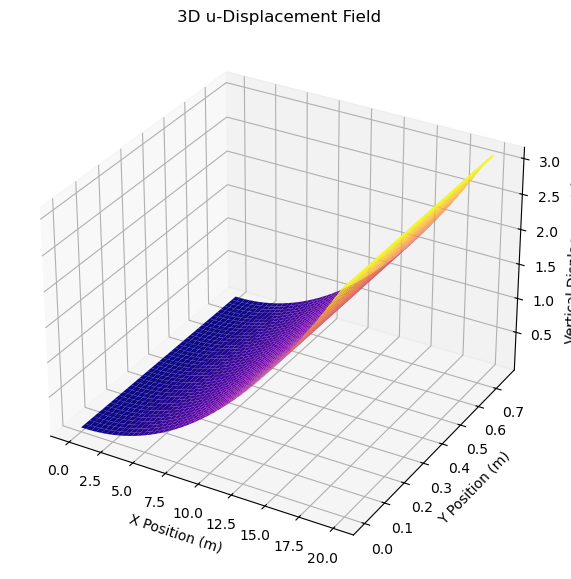

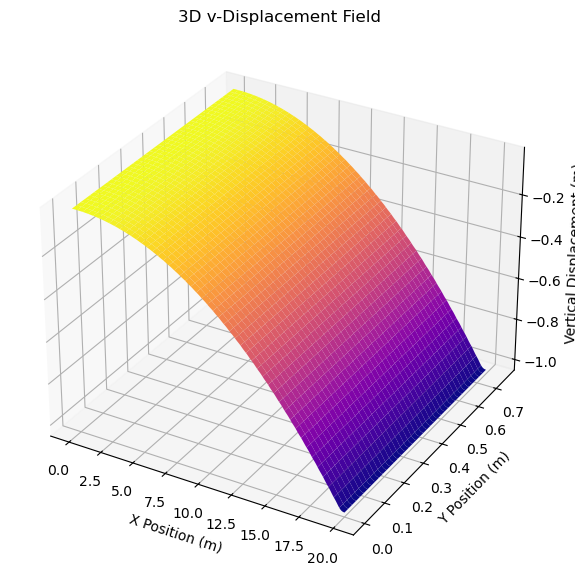

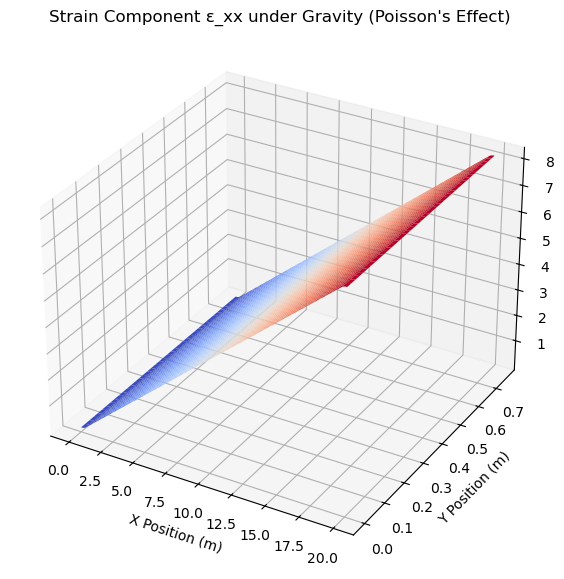

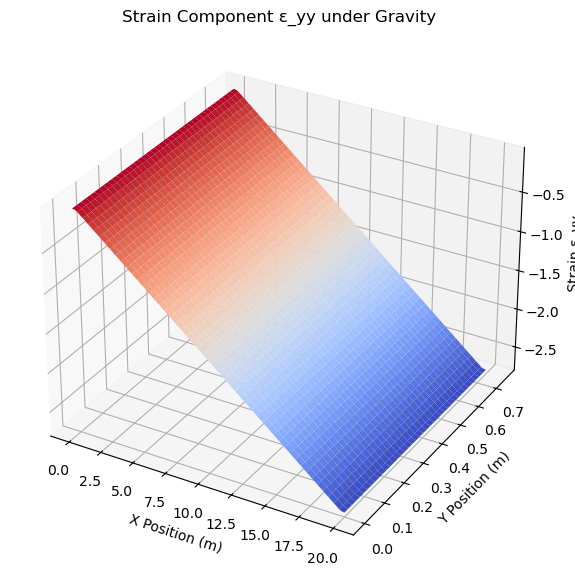

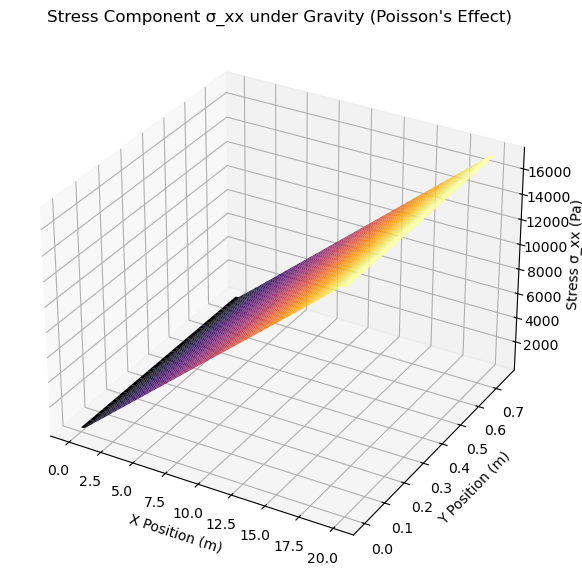

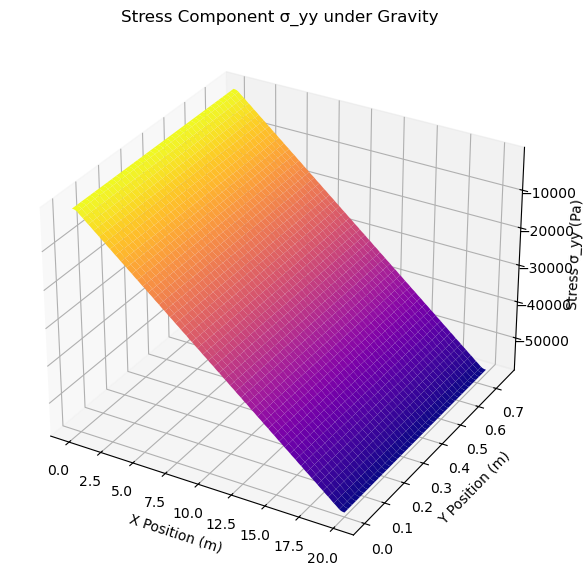

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
# Steel material constants
E = 210e9  # Young's modulus (Pa)
nu = 0.3  # Poisson's ratio
rho = 7850  # Density (kg/m^3)
g = 9.81  # Gravity (m/s^2)

# Plate dimensions
L = 20.0  # Length of the plate (m)
H = 0.75   # Height of the plate (m)
# Generate data points for a grid in x and y (3D surface)
x_vals = np.linspace(0, L, 1000)  # x values
y_vals = np.linspace(0, H, 40)  # y values
x_mesh, y_mesh = np.meshgrid(x_vals,y_vals)
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
# Constants
lambda_ = (E * nu) / ((1 + nu) * (1 - 2 * nu))  # Lame constant λ
mu = E / (2 * (1 + nu))  # Shear modulus μ

# Displacement functions
def displacement_yy_f(y_vals):
    
    return (-rho * g * y_vals**2) / (2 * E)  # Vertical displacement (u_y)

def displacement_xx_f(y_vals):
    return -nu * (-rho * g * y_vals**2) / (2 * E)  # Horizontal displacement due to Poisson effect (u_x)

# Strain components
def strain_yy_f(y_mesh):
    return -(rho * g * y_mesh) / E  # ε_yy (vertical strain)

def strain_xx_f(y_mesh):
    return -nu * strain_yy_f(y_mesh)  # ε_xx (Poisson's effect)

def strain_xy_f(y_mesh):
    # Shear strain caused by Poisson effect and vertical displacement gradient
    strain_xx = -nu * (-(rho * g * y_mesh) / E)  # Horizontal displacement gradient
    strain_yy = -(rho * g * y_mesh) / E  # Vertical displacement gradient
    return 0.5 * (strain_xx + strain_yy)  # ε_xy (shear strain)

# Stress components (Hooke's law for 2D)
def stress_yy_f(y_mesh):
    # Stress in the vertical direction due to gravitational load
    return -rho * g * y_mesh  # σ_yy = -ρgy

def stress_xx_f(y_mesh):
    # Horizontal stress via Poisson effect, scaled by ν
    return -nu * (-rho * g * y_mesh)  # σ_xx = ν * (-ρgy)

def stress_xy_f(y_mesh):
    # Shear stress remains the same (if present, depending on your setup)
    epsilon_xy = strain_xy_f(y_mesh)
    return 2 * mu * epsilon_xy  # σ_xy (shear stress)  
    

# Compute displacement, strain, and stress for each y
# Reshape exact displacements to match model predictions
u_exact = displacement_xx_f(y_flat)   # Horizontal displacement
v_exact = displacement_yy_f(y_flat) # Vertical displacement
print(v_exact)
u_exact = u_exact.reshape(1000, 40)
v_exact = v_exact.reshape(1000, 40)

#u_exact = u_exact.reshape(500,20)
#v_exact = v_exact.reshape(500,20)

epsilon_xx = strain_xx_f(y_flat).reshape(1000, 40).T
epsilon_yy = strain_yy_f(y_flat).reshape(1000, 40).T
epsilon_xy = strain_xy_f(y_flat).reshape(1000, 40).T
sigma_xx = stress_xx_f(y_flat).reshape(1000, 40).T
sigma_yy = stress_yy_f(y_flat).reshape(1000, 40).T
stress_xy =  stress_xy_f(epsilon_xy).reshape(1000, 40).T

u_exact = gaussian_filter(u_exact, sigma=10)  # Adjust sigma as needed
v_exact = gaussian_filter(v_exact, sigma=10)
epsilon_xx =gaussian_filter(epsilon_xx, sigma=10)  # Adjust sigma as needed
epsilon_yy =gaussian_filter(epsilon_yy, sigma=10)
epsilon_xy =gaussian_filter(epsilon_xy, sigma=10)  # Adjust sigma as needed
sigma_xx = gaussian_filter(sigma_xx, sigma=10)
sigma_yy = gaussian_filter(sigma_yy, sigma=10)  # Adjust sigma as needed
stress_xy = gaussian_filter(stress_xy, sigma=10)
# Adapted function to plot exact displacements along x and y
def plot_exact_displacement_along_x_and_y():
    # Compprint(u_exact.shape)ute mean displacements along y for plotting
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(x_vals, u_exact, label="Exact Displacement in u direction (X-axis)", color='r')
    plt.plot(x_vals, v_exact, label="Exact Displacement in v direction (Y-axis)", color='b')
    plt.title("Exact Displacement along the Length of the Beam")
    plt.xlabel("Position along the beam")
    plt.ylabel("Displacement (m)")
    plt.grid(True)
    plt.show()
    # Compprint(u_exact.shape)ute mean displacements along y for plotting


# Call the function to plot exact displacements
plot_exact_displacement_along_x_and_y()
def plot_exact_displacement_3D():
    # Plot horziontal displacement (v) in 3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_mesh, y_mesh, u_exact.T, cmap='plasma')
    
    ax.set_title("3D u-Displacement Field")
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_zlabel('Vertical Displacement (m)')
    plt.show()
    
    # Plot vertical displacement (v) in 3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_mesh, y_mesh, v_exact.T, cmap='plasma')
    
    ax.set_title("3D v-Displacement Field")
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_zlabel('Vertical Displacement (m)')
    plt.show()
    
plot_exact_displacement_3D()
def plot_exact_displacement_Stess_Strain():
    
     # Plot strain component ε_xx in 3D
     fig = plt.figure(figsize=(10, 7))
     ax = fig.add_subplot(111, projection='3d')
     ax.plot_surface(x_mesh, y_mesh, epsilon_xx, cmap='coolwarm')
     
     ax.set_title("Strain Component ε_xx under Gravity (Poisson's Effect)")
     ax.set_xlabel('X Position (m)')
     ax.set_ylabel('Y Position (m)')
     ax.set_zlabel('Strain ε_xx')
     plt.show()
     
     # Plot strain component ε_yy in 3D
     fig = plt.figure(figsize=(10, 7))
     ax = fig.add_subplot(111, projection='3d')
     ax.plot_surface(x_mesh, y_mesh, epsilon_yy, cmap='coolwarm')
     
     ax.set_title("Strain Component ε_yy under Gravity")
     ax.set_xlabel('X Position (m)')
     ax.set_ylabel('Y Position (m)')
     ax.set_zlabel('Strain ε_yy')
     plt.show()
     
     # Plot stress component σ_xx in 3D
     fig = plt.figure(figsize=(10, 7))
     ax = fig.add_subplot(111, projection='3d')
     ax.plot_surface(x_mesh, y_mesh, sigma_xx, cmap='inferno')
     
     ax.set_title("Stress Component σ_xx under Gravity (Poisson's Effect)")
     ax.set_xlabel('X Position (m)')
     ax.set_ylabel('Y Position (m)')
     ax.set_zlabel('Stress σ_xx (Pa)')
     plt.show()
     
     # Plot stress component σ_yy in 3D
     fig = plt.figure(figsize=(10, 7))
     ax = fig.add_subplot(111, projection='3d')
     ax.plot_surface(x_mesh, y_mesh, sigma_yy, cmap='plasma')
     
     ax.set_title("Stress Component σ_yy under Gravity")
     ax.set_xlabel('X Position (m)')
     ax.set_ylabel('Y Position (m)')
     ax.set_zlabel('Stress σ_yy (Pa)')
     plt.show()

plot_exact_displacement_Stess_Strain()



DENEME
(40000,)


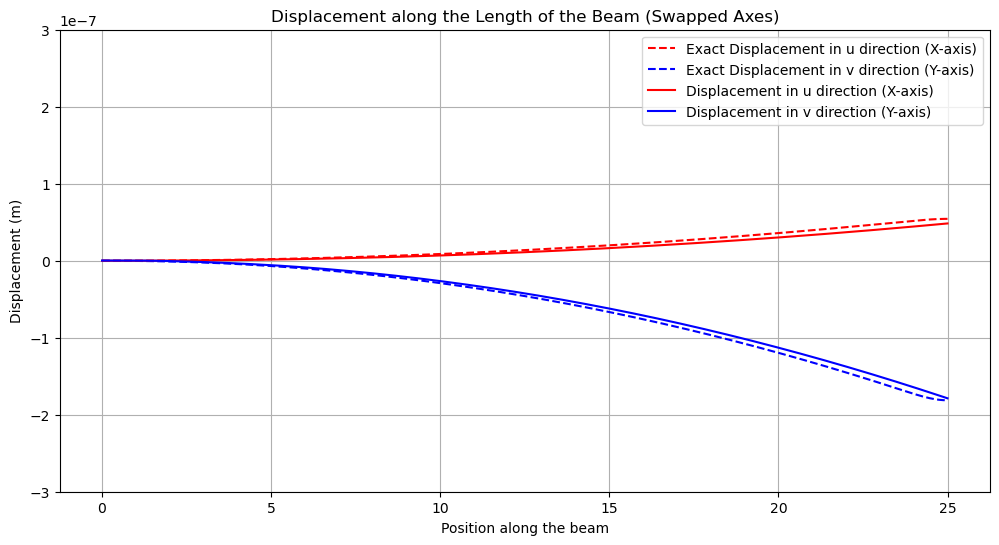

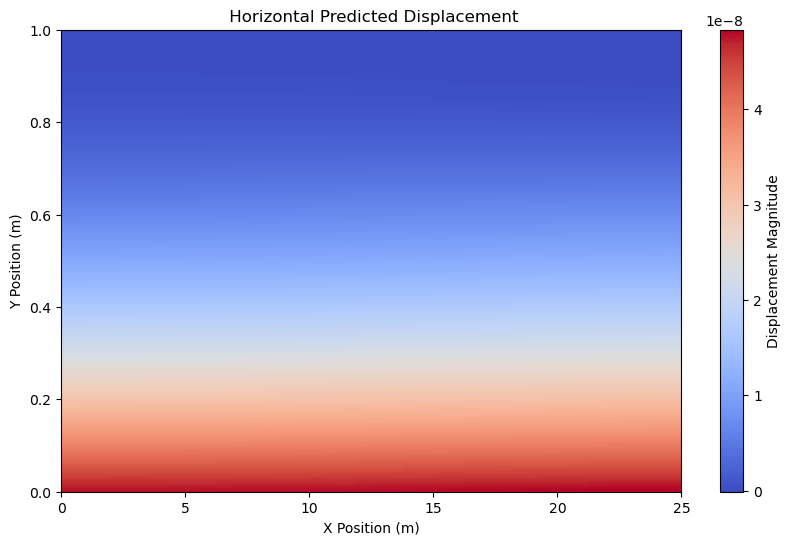

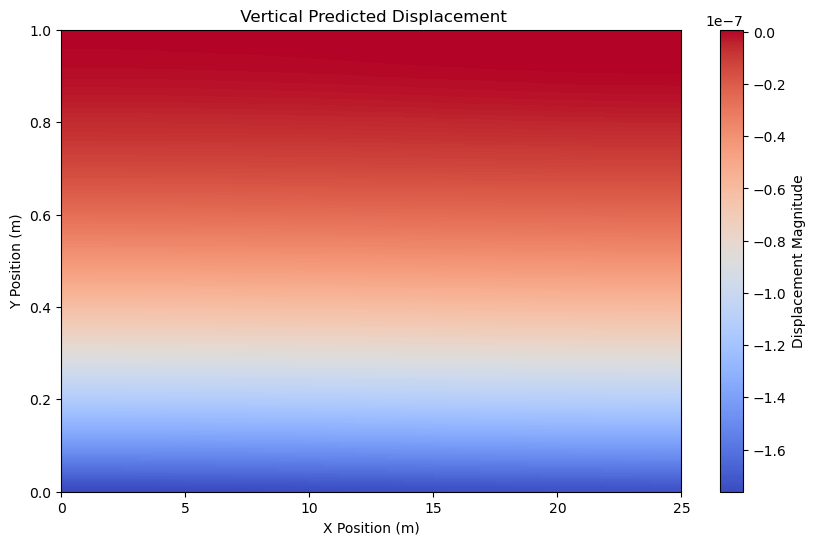

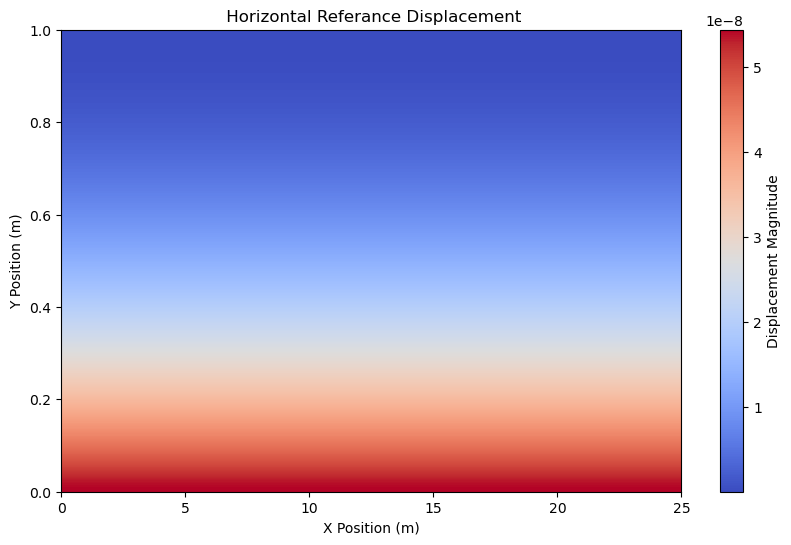

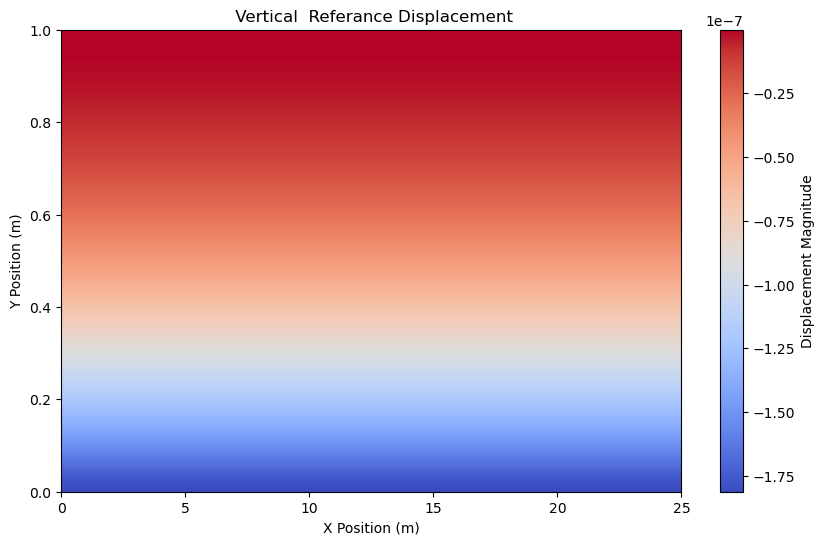

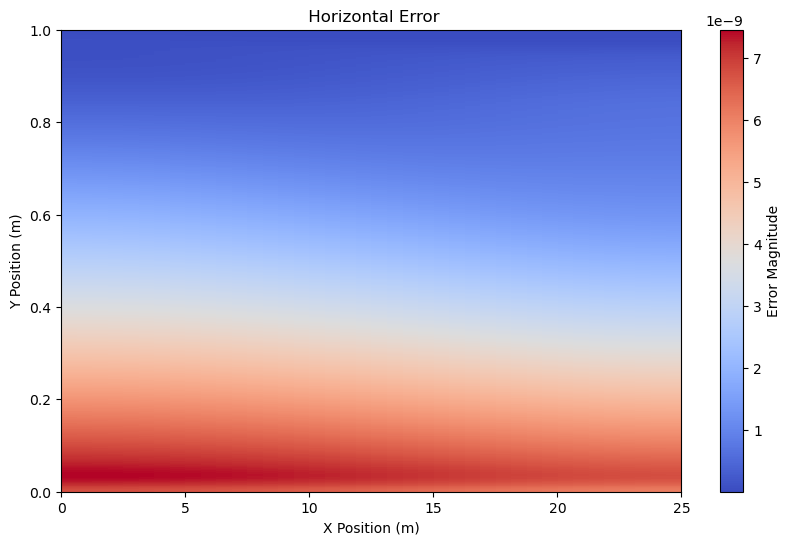

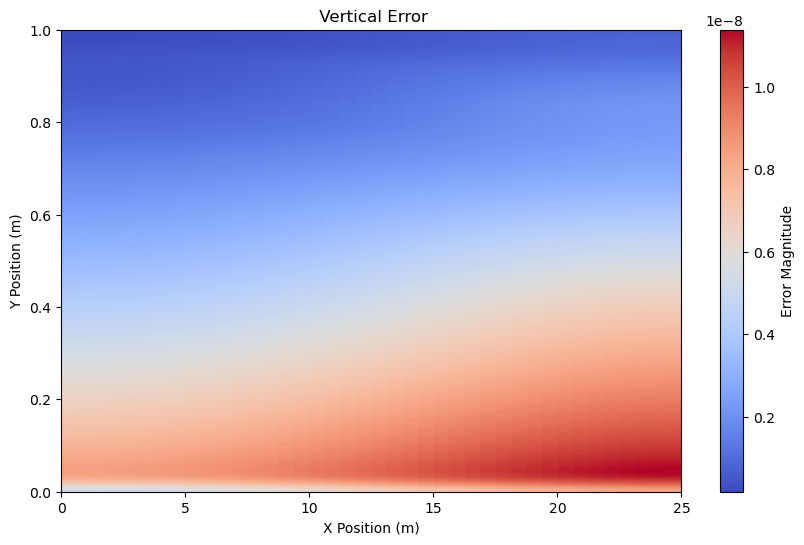

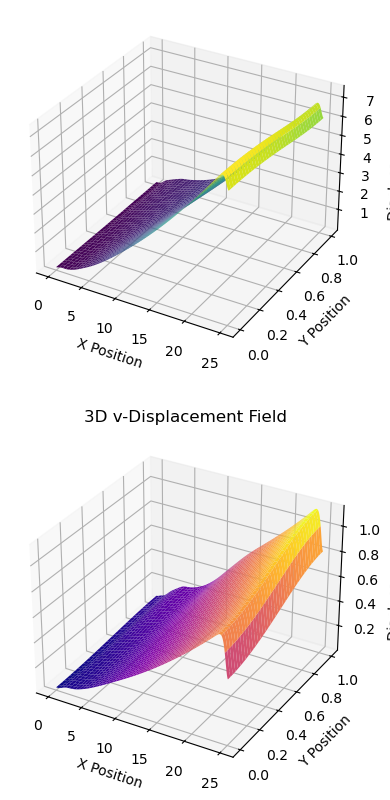

Predicted u_max: 4.94e-08, u_min: -1.71e-10,  u_mean: 1.57e-08, v_max: 1.13e-09, v_min: -1.80e-07, v_mean: -5.73e-08
Exact u_max: 5.44e-08, u_min: 9.01e-12,  u_mean: 1.86e-08, v_max: -3.00e-11, v_min: -1.81e-07, v_mean: -6.19e-08
Max Error in X direction: 7.45e-09 at position (963, 0)
Min Error in X direction: 1.14e-11 at position (0, 18)
Max Error in Y direction: 1.14e-08 at position (954, 39)
Min Error in Y direction: 1.89e-10 at position (0, 0)
Average error in X: 2.89e-09
Average error in Y: 4.63e-09
Standard deviation of the error in X: 2.26e-09
Standard deviation of the error in Y: 2.99e-09


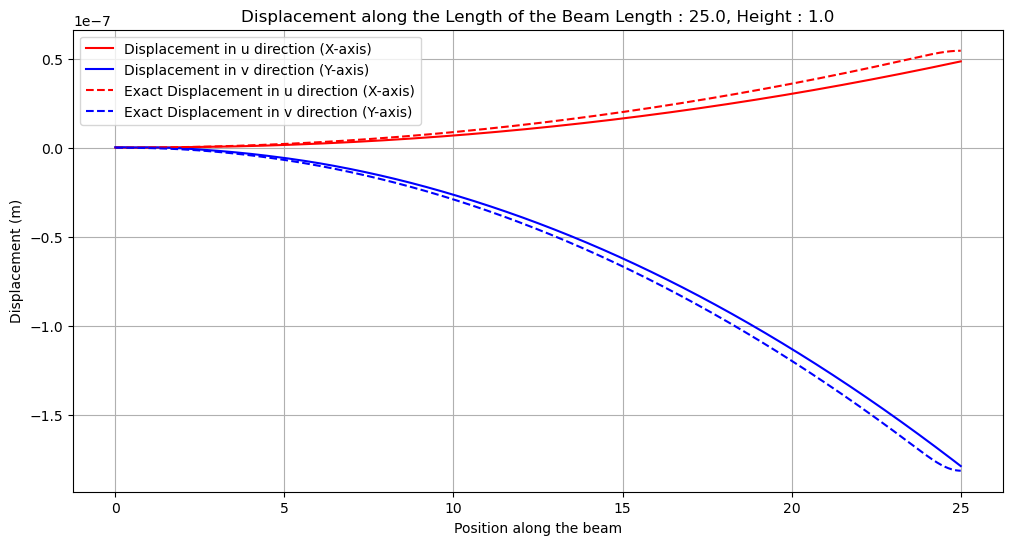

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
L = 25.0  # Length of the plate (m)
H = 1.0  # Height of the plate (m)
x_vals = np.linspace(0, L, 1000)  # x values
y_vals = np.linspace(0, H, 40)  # y values
x_mesh, y_mesh = np.meshgrid(x_vals,y_vals)
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()

def dimensionalize_displacement(u_nd, v_nd, scale_factor):
        return u_nd * u_char * scale_factor, v_nd * v_char * scale_factor

 # Get model predictions (non-dimensional displacements)
u_displacement_nd = np.array([model_2D(x, y)[0] for x in x_vals for y in y_vals]).reshape(1000,40) # Swap u and v
v_displacement_nd = np.array([model_2D(x, y)[1] for x in x_vals for y in y_vals]).reshape(1000,40)  # Swap u and v
# Apply re-dimensionalization
u_displacement, v_displacement = dimensionalize_displacement(u_displacement_nd, v_displacement_nd,1e-3)
# Compute mean displacements along y and x for plotting
u_mean = u_displacement_nd.mean(axis=1)
v_mean = v_displacement_nd.mean(axis=1)

# Function to smooth data using spline interpolation
def smooth_data(x, y, smooth_factor=300):
    spline = make_interp_spline(x, y, k=3)  # k=3 for cubic spline
    x_new = np.linspace(x.min(), x.max(), smooth_factor)
    y_smooth = spline(x_new)
    return x_new, y_smooth

# Replace Gaussian filter with B-spline smoothing for both predicted and exact displacements
def compute_smoothed_displacement(u_displacement, v_displacement, x_vals, y_vals):
    # Smooth the displacements using B-spline interpolation
    u_smooth_x, u_smooth_vals = smooth_data(x_vals, u_displacement[:, 10])
    v_smooth_x, v_smooth_vals = smooth_data(x_vals, v_displacement[:, 10])
    
    return u_smooth_x, u_smooth_vals, v_smooth_x, v_smooth_vals

# Displacement'lardan türevler alarak strain hesaplama
def compute_strain(u_displacement, v_displacement, x_vals, y_vals):
    # Initialize arrays to store strain components
    epsilon_xx = np.zeros((len(x_vals), len(y_vals)))
    epsilon_yy = np.zeros((len(x_vals), len(y_vals)))
    epsilon_xy = np.zeros((len(x_vals), len(y_vals)))

    # Iterate over x and y values to compute gradients and strain
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
             u_x = jax.grad(lambda x: model_2D(x, y)[0])(x)
             u_y = jax.grad(lambda y: model_2D(x, y)[0])(y)
             v_x = jax.grad(lambda x: model_2D(x, y)[1])(x)
             v_y = jax.grad(lambda y: model_2D(x, y)[1])(y)
             
             # Strain components in 2D
             epsilon_xx[i, j] = u_x
             epsilon_yy[i, j] = v_y
             epsilon_xy[i, j] = 0.5 * (u_y + v_x)

    return epsilon_xx, epsilon_yy, epsilon_xy
    
def compute_stress(epsilon_xx, epsilon_yy, epsilon_xy):
    # Using Hooke's Law for stress
    sigma_xx = lambda_ * (epsilon_xx + epsilon_yy) + 2 * mu * epsilon_xx
    sigma_yy = lambda_ * (epsilon_xx + epsilon_yy) + 2 * mu * epsilon_yy
    sigma_xy = 2 * mu * epsilon_xy

    return sigma_xx, sigma_yy, sigma_xy

print("DENEME")
u_displacement_pred, v_displacement_pred = dimensionalize_displacement(u_displacement_nd, v_displacement_nd,1e-3)
#u_displacement_pred, v_displacement_pred =  compute_smoothed_displacement(u_displacement_pred, v_displacement_pred, x_vals, y_vals)
u_displacement_pred = gaussian_filter(u_displacement_pred, sigma=10)  # Adjust sigma as needed
v_displacement_pred = gaussian_filter(v_displacement_pred, sigma=10)
# For predicted displacement

# Compute exact displacements, strain, and stress for each y
u_exact = displacement_xx_f(y_mesh)  # Horizontal displacement
v_exact = displacement_yy_f(y_mesh)  # Vertical displacement
u_exact = u_exact.reshape(1000,40)
v_exact = v_exact.reshape(1000,40)
#u_exact, v_exact =  compute_smoothed_displacement(u_exact, v_exact, x_vals, y_vals)
u_exact = gaussian_filter(u_exact, sigma=20)  # Adjust sigma as needed
v_exact = gaussian_filter(v_exact, sigma=20)

error_displacement_X = np.abs(u_displacement_pred - u_exact)
error_displacement_Y = np.abs(v_displacement_pred - v_exact)


def plot_displacement_along_x_and_y():
    print(x_flat.shape)
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(x_vals, u_exact[:,10], label="Exact Displacement in u direction (X-axis)", color='r', ls="--")
    plt.plot(x_vals, v_exact[:,10], label="Exact Displacement in v direction (Y-axis)", color='b', ls="--")
    plt.plot(x_vals, u_displacement[:,10], label="Displacement in u direction (X-axis)", color='r')  # Swap color
    plt.plot(x_vals, v_displacement[:,10], label="Displacement in v direction (Y-axis)", color='b')  # Swap color
    plt.title("Displacement along the Length of the Beam (Swapped Axes)")
    plt.xlabel("Position along the beam")
    plt.ylabel("Displacement (m)")
    plt.legend()
    plt.ylim(-3e-7,3e-7)
    plt.grid(True)
    plt.show()


plot_displacement_along_x_and_y()

# Plot heatmap for displacements (Predicted and Exact)
def plot_displacement_heatmap(displacement_matrix, title):
    plt.figure(figsize=(10, 6))
    plt.imshow(displacement_matrix, cmap='coolwarm', interpolation='nearest', extent=[0, 25, 0, 1], aspect='auto')
    plt.title(title)
    plt.colorbar(label="Displacement Magnitude")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.show()

plot_displacement_heatmap(u_displacement_pred, " Horizontal Predicted Displacement")
plot_displacement_heatmap(v_displacement_pred, " Vertical Predicted Displacement")
plot_displacement_heatmap(u_exact, " Horizontal Referance Displacement")
plot_displacement_heatmap(v_exact, " Vertical  Referance Displacement")

# Plot heatmap for displacement error (X and Y direction)
def plot_error_heatmap(error_matrix, title):
    plt.figure(figsize=(10, 6))
    plt.imshow(error_matrix, cmap='coolwarm', interpolation='nearest', extent=[0, 25, 0, 1], aspect='auto')
    plt.title(title)
    plt.colorbar(label="Error Magnitude")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.ylim()
    plt.show()

plot_error_heatmap(error_displacement_X, " Horizontal Error")
plot_error_heatmap(error_displacement_Y, " Vertical Error")

# 3D Visualization for 2D Elasticity Model
def plot_3d_displacement_field_():
    # Create a 3D plot for u and v displacement fields
    fig = plt.figure(figsize=(12, 10))
    # Plot u displacement field
    ax1 = fig.add_subplot(211, projection='3d')
    ax1.plot_surface(x_mesh, y_mesh, error_displacement_X.T, cmap='viridis')
    ax1.set_xlabel("X Position")
    ax1.set_ylabel("Y Position")
    ax1.set_zlabel("Displacement u (m)")
    # Plot v displacement field
    ax2 = fig.add_subplot(212, projection='3d')
    ax2.plot_surface(x_mesh, y_mesh, error_displacement_Y.T, cmap='plasma')
    ax2.set_title("3D v-Displacement Field")
    ax2.set_xlabel("X Position")
    ax2.set_ylabel("Y Position")
    ax2.set_zlabel("Displacement v (m)")
    plt.show()

plot_3d_displacement_field_()
# Call the function with your trained model
def calculate_min_max_displacement(u_displacement_pred, v_displacement_pred, u_exact, v_exact):
    u_pred_max = np.max(u_displacement_pred)
    u_pred_min = np.min(u_displacement_pred)
    u_pred_avg = np.mean(u_displacement_pred)
    v_pred_max = np.max(v_displacement_pred)
    v_pred_min = np.min(v_displacement_pred)
    v_pred_avg = np.mean(v_displacement_pred)
    
    u_exact_max = np.max(u_exact)
    u_exact_min = np.min(u_exact)
    u_exact_avg = np.mean(u_exact)
    v_exact_max = np.max(v_exact)
    v_exact_min = np.min(v_exact)
    v_exact_avg = np.mean(v_exact)
    return (u_pred_max, u_pred_min,u_pred_avg ,v_pred_max, v_pred_min, v_pred_avg,
            u_exact_max, u_exact_min, u_exact_avg, v_exact_max, v_exact_min,v_exact_avg)
# Call the function and print results
results = calculate_min_max_displacement(u_displacement, v_displacement, u_exact, v_exact)
print(f"Predicted u_max: {results[0]:.2e}, u_min: {results[1]:.2e},  u_mean: {results[2]:.2e}, v_max: {results[3]:.2e}, v_min: {results[4]:.2e}, v_mean: {results[5]:.2e}")
print(f"Exact u_max: {results[6]:.2e}, u_min: {results[7]:.2e},  u_mean: {results[8]:.2e}, v_max: {results[9]:.2e}, v_min: {results[10]:.2e}, v_mean: {results[11]:.2e}")
# Calculate max, min, average, and standard deviation of errors
error_max_X = np.max(error_displacement_X)
error_min_X = np.min(error_displacement_X)
error_avg_X = np.mean(error_displacement_X)
error_std_X = np.std(error_displacement_X)

error_max_Y = np.max(error_displacement_Y)
error_min_Y = np.min(error_displacement_Y)
error_avg_Y = np.mean(error_displacement_Y)
error_std_Y = np.std(error_displacement_Y)

# Get the positions (coordinates) of max/min errors in X and Y directions
error_max_X_pos = np.unravel_index(np.argmax(error_displacement_X), error_displacement_X.shape)
error_min_X_pos = np.unravel_index(np.argmin(error_displacement_X), error_displacement_X.shape)

error_max_Y_pos = np.unravel_index(np.argmax(error_displacement_Y), error_displacement_Y.shape)
error_min_Y_pos = np.unravel_index(np.argmin(error_displacement_Y), error_displacement_Y.shape)
# Print the results
print(f"Max Error in X direction: {error_max_X:.2e} at position {error_max_X_pos}")
print(f"Min Error in X direction: {error_min_X:.2e} at position {error_min_X_pos}")
print(f"Max Error in Y direction: {error_max_Y:.2e} at position {error_max_Y_pos}")
print(f"Min Error in Y direction: {error_min_Y:.2e} at position {error_min_Y_pos}")
print(f"Average error in X: {error_avg_X:.2e}")
print(f"Average error in Y: {error_avg_Y:.2e}")
print(f"Standard deviation of the error in X: {error_std_X:.2e}")
print(f"Standard deviation of the error in Y: {error_std_Y:.2e}")
plt.figure(figsize=(12, 6))
plt.plot(x_vals, u_displacement[:, 10], label="Displacement in u direction (X-axis)", color='r')
plt.plot(x_vals, v_displacement[:, 10], label="Displacement in v direction (Y-axis)", color='b')
plt.plot(x_vals, u_exact[:, 10], label="Exact Displacement in u direction (X-axis)", color='r', ls="--")
plt.plot(x_vals, v_exact[:, 10], label="Exact Displacement in v direction (Y-axis)", color='b',ls="--")
plt.title(f"Displacement along the Length of the Beam Length : {L}, Height : {H}")
plt.xlabel("Position along the beam")
plt.ylabel("Displacement (m)")
plt.legend()
plt.grid(True)
plt.show()

Predicted u_max: 6.07e-09, u_min: -4.09e-11,  u_mean: 1.88e-09, v_max: 1.95e-10, v_min: -2.27e-08, v_mean: -7.15e-09
Exact u_max: 1.98e-08, u_min: 1.62e-13,  u_mean: 6.69e-09, v_max: -5.40e-13, v_min: -6.60e-08, v_mean: -2.23e-08
Max Error in X direction: 1.40e-08 at position (990, 0)
Min Error in X direction: 1.68e-14 at position (0, 11)
Max Error in Y direction: 4.41e-08 at position (989, 39)
Min Error in Y direction: 2.31e-13 at position (4, 0)
Average error in X: 4.80e-09
Average error in Y: 1.51e-08
Standard deviation of the error in X: 4.28e-09
Standard deviation of the error in Y: 1.35e-08


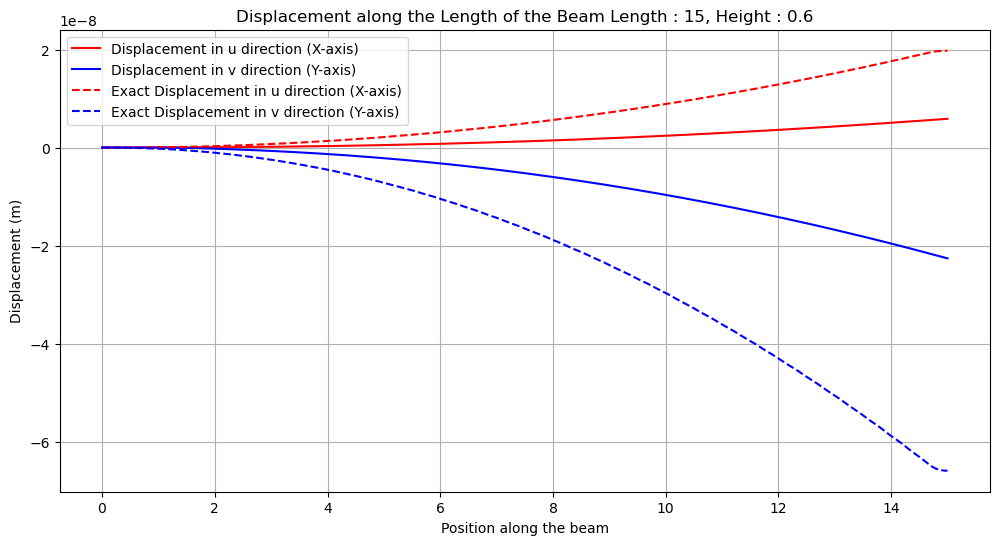

Predicted u_max: 1.99e-08, u_min: -9.28e-11,  u_mean: 6.26e-09, v_max: 5.35e-10, v_min: -7.32e-08, v_mean: -2.32e-08
Exact u_max: 3.52e-08, u_min: 2.88e-13,  u_mean: 1.19e-08, v_max: -9.60e-13, v_min: -1.17e-07, v_mean: -3.96e-08
Max Error in X direction: 1.61e-08 at position (985, 4)
Min Error in X direction: 1.03e-14 at position (23, 33)
Max Error in Y direction: 4.73e-08 at position (984, 39)
Min Error in Y direction: 1.17e-13 at position (3, 0)
Average error in X: 5.62e-09
Average error in Y: 1.64e-08
Standard deviation of the error in X: 4.92e-09
Standard deviation of the error in Y: 1.42e-08


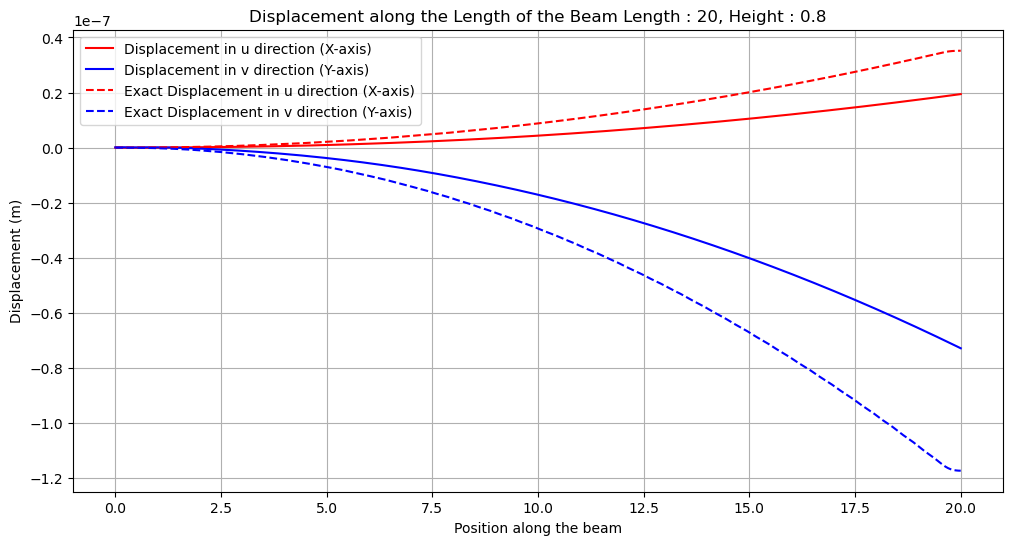

Predicted u_max: 4.97e-08, u_min: -1.72e-10,  u_mean: 1.58e-08, v_max: 1.14e-09, v_min: -1.81e-07, v_mean: -5.76e-08
Exact u_max: 5.50e-08, u_min: 4.50e-13,  u_mean: 1.86e-08, v_max: -1.50e-12, v_min: -1.83e-07, v_mean: -6.19e-08
Max Error in X direction: 7.49e-09 at position (979, 5)
Min Error in X direction: 1.06e-14 at position (1, 3)
Max Error in Y direction: 1.20e-08 at position (978, 39)
Min Error in Y direction: 8.35e-13 at position (0, 0)
Average error in X: 2.78e-09
Average error in Y: 4.26e-09
Standard deviation of the error in X: 2.20e-09
Standard deviation of the error in Y: 2.82e-09


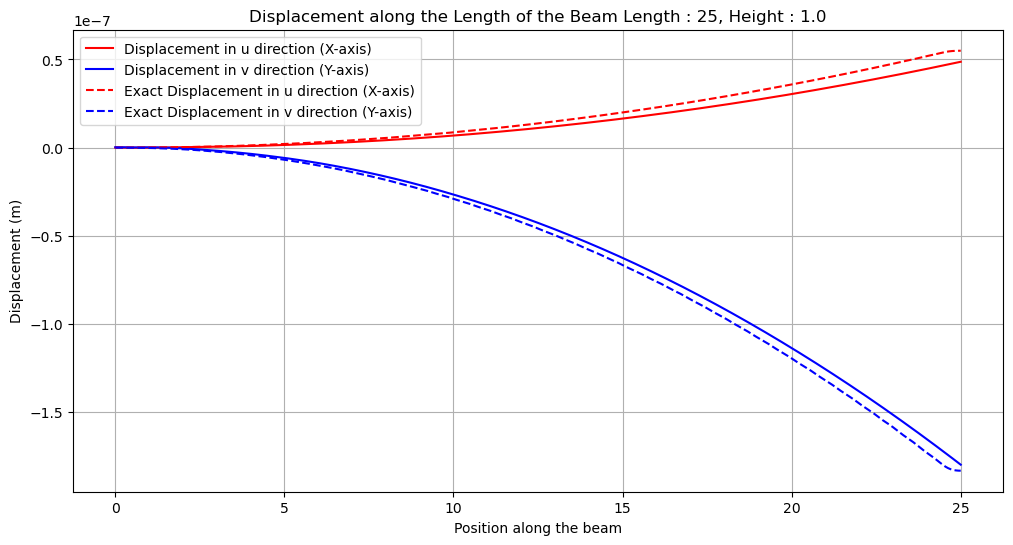

Predicted u_max: 1.05e-07, u_min: -3.00e-10,  u_mean: 3.35e-08, v_max: 2.04e-09, v_min: -3.78e-07, v_mean: -1.21e-07
Exact u_max: 7.92e-08, u_min: 6.48e-13,  u_mean: 2.67e-08, v_max: -2.16e-12, v_min: -2.64e-07, v_mean: -8.91e-08
Max Error in X direction: 2.55e-08 at position (999, 39)
Min Error in X direction: 4.47e-14 at position (50, 1)
Max Error in Y direction: 1.14e-07 at position (999, 0)
Min Error in Y direction: 2.16e-13 at position (2, 0)
Average error in X: 6.79e-09
Average error in Y: 3.19e-08
Standard deviation of the error in X: 6.65e-09
Standard deviation of the error in Y: 3.08e-08


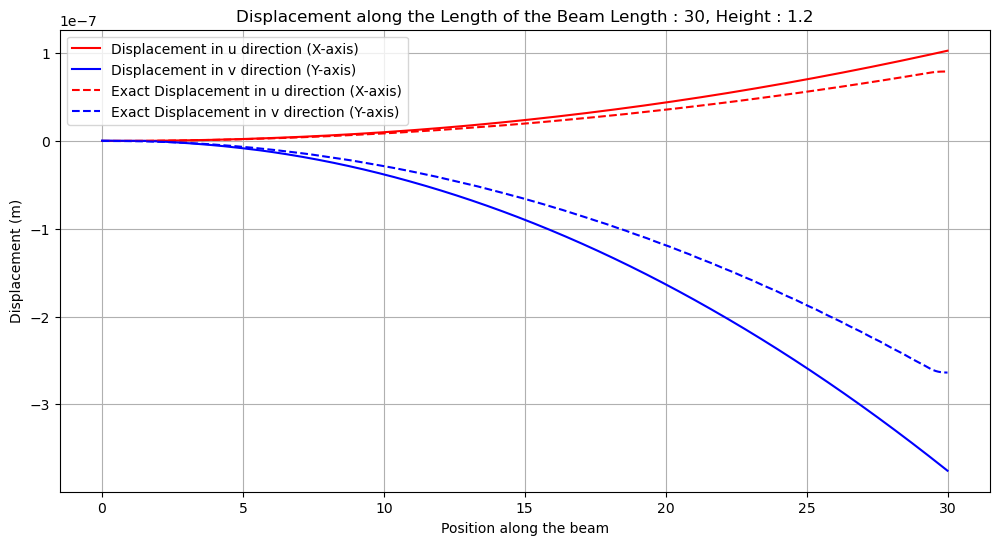

Predicted u_max: 3.37e-07, u_min: -8.13e-10,  u_mean: 1.09e-07, v_max: 5.37e-09, v_min: -1.21e-06, v_mean: -3.86e-07
Exact u_max: 1.41e-07, u_min: 1.15e-12,  u_mean: 4.75e-08, v_max: -3.84e-12, v_min: -4.69e-07, v_mean: -1.58e-07
Max Error in X direction: 1.96e-07 at position (999, 39)
Min Error in X direction: 1.01e-13 at position (0, 17)
Max Error in Y direction: 7.37e-07 at position (999, 0)
Min Error in Y direction: 2.20e-13 at position (5, 0)
Average error in X: 6.13e-08
Average error in Y: 2.28e-07
Standard deviation of the error in X: 5.66e-08
Standard deviation of the error in Y: 2.12e-07


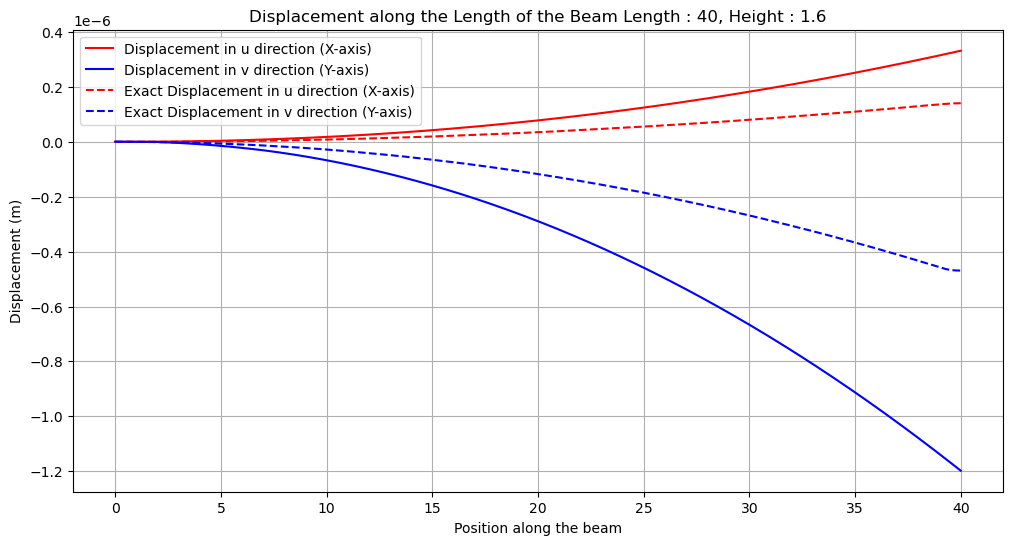

Predicted u_max: 5.43e-07, u_min: -1.32e-09,  u_mean: 1.76e-07, v_max: 8.06e-09, v_min: -1.94e-06, v_mean: -6.22e-07
Exact u_max: 1.78e-07, u_min: 1.46e-12,  u_mean: 6.02e-08, v_max: -4.86e-12, v_min: -5.94e-07, v_mean: -2.01e-07
Max Error in X direction: 3.65e-07 at position (999, 39)
Min Error in X direction: 3.40e-13 at position (0, 11)
Max Error in Y direction: 1.34e-06 at position (999, 0)
Min Error in Y direction: 1.08e-12 at position (39, 6)
Average error in X: 1.16e-07
Average error in Y: 4.22e-07
Standard deviation of the error in X: 1.06e-07
Standard deviation of the error in Y: 3.90e-07


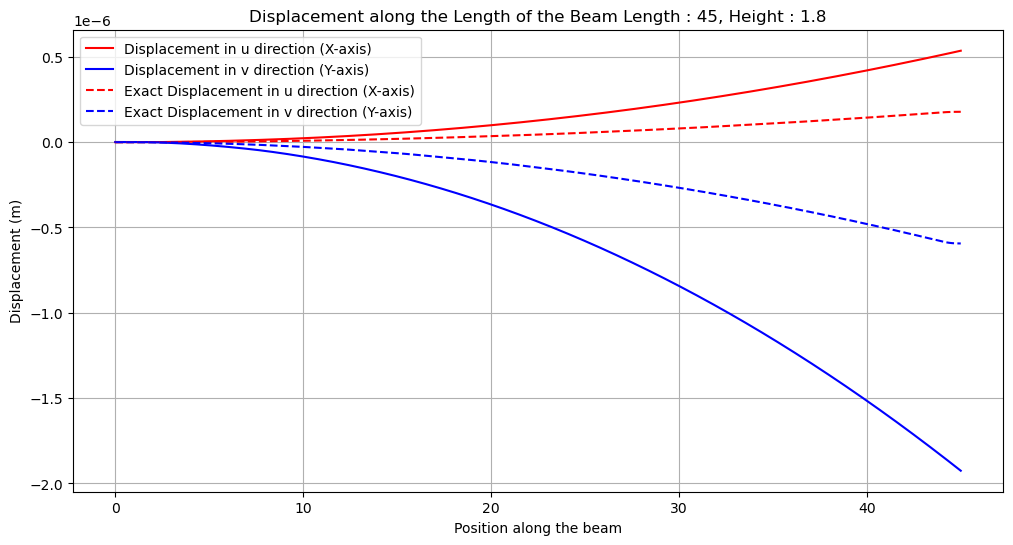

In [5]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

L = [15, 20, 25,30,40,45,50 ] # Length of the plate (m)
H = [L_val * (40 / 1000) for L_val in L]   # Height of the plate (m)
# Updated function to apply non-dimensionalization to the inputs during testing
def plot_displacement_along_x_and_y(model, L, H):
    model = eqx.filter_jit(model)
    u_char = nu *rho * g * L**2 / (E * 2)
    v_char = rho * g * L**2 / (E * 2)
    # Dimensionalize functions
    def dimensionalize_displacement(u_nd, v_nd, scale_factor):
        return u_nd * u_char * scale_factor, v_nd * v_char * scale_factor
    # Generate mesh grid for x and y values
    x_vals = np.linspace(0, L, 1000)
    y_vals = np.linspace(0, H, 40)
    x_mesh, y_mesh = np.meshgrid(x_vals,y_vals)
    x_flat = x_mesh.flatten()
    y_flat = y_mesh.flatten()


    # Get model predictions (non-dimensional displacements)
    u_displacement_nd = np.array([model(x, y)[0] for x in x_vals for y in y_vals]).reshape(1000, 40)
    v_displacement_nd = np.array([model(x, y)[1] for x in x_vals for y in y_vals]).reshape(1000, 40)

    # Apply re-dimensionalization to the predictions
    u_displacement, v_displacement = dimensionalize_displacement(u_displacement_nd, v_displacement_nd, 1e-3)
    # Displacement functions
    def displacement_yy_f(y_vals):
        
        return (-rho * g * y_vals**2) / (2 * E)  # Vertical displacement (u_y)
    
    def displacement_xx_f(y_vals):
        return -nu * (-rho * g * y_vals**2) / (2 * E)  # Horizontal displacement due to Poisson effect (u_x)
    
    u_exact = displacement_xx_f(y_flat)   # Horizontal displacement
    v_exact = displacement_yy_f(y_flat) # Vertical displacement
    u_exact = u_exact.reshape(1000, 40)
    v_exact = v_exact.reshape(1000, 40)
    u_exact = gaussian_filter(u_exact, sigma=10)  # Adjust sigma as needed
    v_exact = gaussian_filter(v_exact, sigma=10)
    # Adapted function to plot exact displacements along x and y
    # Compprint(u_exact.shape)ute mean displacements along y for plotting
    # Plot the results

    # Compprint(u_exact.shape)ute mean displacements along y for plotting
    # Plot the results
    def calculate_min_max_displacement(u_displacement_pred, v_displacement_pred, u_exact, v_exact):
        u_pred_max = np.max(u_displacement_pred)
        u_pred_min = np.min(u_displacement_pred)
        u_pred_avg = np.mean(u_displacement_pred)
        v_pred_max = np.max(v_displacement_pred)
        v_pred_min = np.min(v_displacement_pred)
        v_pred_avg = np.mean(v_displacement_pred)
        
        u_exact_max = np.max(u_exact)
        u_exact_min = np.min(u_exact)
        u_exact_avg = np.mean(u_exact)
        v_exact_max = np.max(v_exact)
        v_exact_min = np.min(v_exact)
        v_exact_avg = np.mean(v_exact)
        return (u_pred_max, u_pred_min,u_pred_avg ,v_pred_max, v_pred_min, v_pred_avg,
                u_exact_max, u_exact_min, u_exact_avg, v_exact_max, v_exact_min,v_exact_avg)

    # Call the function and print results
    results = calculate_min_max_displacement(u_displacement, v_displacement, u_exact, v_exact)
    print(f"Predicted u_max: {results[0]:.2e}, u_min: {results[1]:.2e},  u_mean: {results[2]:.2e}, v_max: {results[3]:.2e}, v_min: {results[4]:.2e}, v_mean: {results[5]:.2e}")
    print(f"Exact u_max: {results[6]:.2e}, u_min: {results[7]:.2e},  u_mean: {results[8]:.2e}, v_max: {results[9]:.2e}, v_min: {results[10]:.2e}, v_mean: {results[11]:.2e}")

    error_displacement_X = np.abs(u_displacement - u_exact)
    error_displacement_Y = np.abs(v_displacement - v_exact)
    
    # Calculate max, min, average, and standard deviation of errors
    error_max_X = np.max(error_displacement_X)
    error_min_X = np.min(error_displacement_X)
    error_avg_X = np.mean(error_displacement_X)
    error_std_X = np.std(error_displacement_X)
    
    error_max_Y = np.max(error_displacement_Y)
    error_min_Y = np.min(error_displacement_Y)
    error_avg_Y = np.mean(error_displacement_Y)
    error_std_Y = np.std(error_displacement_Y)
    
    # Get the positions (coordinates) of max/min errors in X and Y directions
    error_max_X_pos = np.unravel_index(np.argmax(error_displacement_X), error_displacement_X.shape)
    error_min_X_pos = np.unravel_index(np.argmin(error_displacement_X), error_displacement_X.shape)
    
    error_max_Y_pos = np.unravel_index(np.argmax(error_displacement_Y), error_displacement_Y.shape)
    error_min_Y_pos = np.unravel_index(np.argmin(error_displacement_Y), error_displacement_Y.shape)

    # Print the results
    print(f"Max Error in X direction: {error_max_X:.2e} at position {error_max_X_pos}")
    print(f"Min Error in X direction: {error_min_X:.2e} at position {error_min_X_pos}")
    print(f"Max Error in Y direction: {error_max_Y:.2e} at position {error_max_Y_pos}")
    print(f"Min Error in Y direction: {error_min_Y:.2e} at position {error_min_Y_pos}")
    print(f"Average error in X: {error_avg_X:.2e}")
    print(f"Average error in Y: {error_avg_Y:.2e}")
    print(f"Standard deviation of the error in X: {error_std_X:.2e}")
    print(f"Standard deviation of the error in Y: {error_std_Y:.2e}")


    plt.figure(figsize=(12, 6))
    plt.plot(x_vals, u_displacement[:, 10], label="Displacement in u direction (X-axis)", color='r')
    plt.plot(x_vals, v_displacement[:, 10], label="Displacement in v direction (Y-axis)", color='b')
    plt.plot(x_vals, u_exact[:, 10], label="Exact Displacement in u direction (X-axis)", color='r', ls="--")
    plt.plot(x_vals, v_exact[:, 10], label="Exact Displacement in v direction (Y-axis)", color='b',ls="--")
    plt.title(f"Displacement along the Length of the Beam Length : {L}, Height : {H}")
    plt.xlabel("Position along the beam")
    plt.ylabel("Displacement (m)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
  

for i in [0,1,2,3,4,5]:
    plot_displacement_along_x_and_y(model_2D, L[i], H[i])